In [1]:
%matplotlib inline

import os 

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pystan import StanModel

In [2]:
DATA_FOLDER = '../data'
MILK_FULLPATH = os.path.join(DATA_FOLDER, 'milk.csv')

In [3]:
milk = pd.read_csv(MILK_FULLPATH)
milk.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


In [4]:
milk.describe()

,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
count,29.000000,29.000000,29.000000,29.000000,29.000000,17.000000
mean,0.641724,33.990345,16.403448,49.606207,14.726897,67.575882
std,0.161402,14.286670,4.846878,14.055174,24.770469,5.968612
min,0.460000,3.930000,7.370000,27.090000,0.120000,55.160000
25%,0.490000,21.220000,13.000000,37.800000,1.620000,64.540000
50%,0.600000,36.840000,15.800000,48.640000,3.470000,68.850000
75%,0.730000,46.080000,20.770000,60.120000,10.720000,71.260000
max,0.970000,55.510000,25.300000,71.910000,97.720000,76.300000


In [5]:
cortex_code = """
data {
    int<lower=0> N;
    vector[N] X;
    vector[N] kcal_per_g;
}
parameters {
    real alpha;
    real beta;
    real<lower=0> sigma;

}
transformed parameters {
    vector[N] mu;
    
    mu = alpha + beta * X;
}
model {
    alpha ~ normal(0, 100);
    beta ~ normal(0, 1);
    //sigma ~ uniform(0, 1);
    kcal_per_g ~ normal(mu, sigma);
}"""

sm1 = StanModel(model_code=cortex_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_aa94fcbabf321b641ccd10524dd27798 NOW.


In [6]:
cortex_data = dict(
    N=milk.shape[0],
    X=milk.loc[:, 'neocortex.perc'],
    kcal_per_g=milk.loc[:, 'kcal.per.g']
)

fit1_1 = sm1.sampling(data=cortex_data)
fit1_1

RuntimeError: Initialization failed.

This failure is due to the missing values in the `neocortex.perc` feature.

In [7]:
mask = np.sum(milk.isna(), axis=1) >= 1
milk_cc = milk[~mask]
milk_cc.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
5,New World Monkey,Alouatta seniculus,0.47,21.22,23.58,55.20,5.25,64.54
6,New World Monkey,A palliata,0.56,29.66,23.46,46.88,5.37,64.54
7,New World Monkey,Cebus apella,0.89,53.41,15.80,30.79,2.51,67.64
9,New World Monkey,S sciureus,0.92,50.58,22.33,27.09,0.68,68.85


In [8]:
cortex_data = dict(
    N=milk_cc.shape[0],
    X=milk_cc.loc[:, 'neocortex.perc'],
    kcal_per_g=milk_cc.loc[:, 'kcal.per.g']
)

fit1_2 = sm1.sampling(data=cortex_data)
fit1_2

Inference for Stan model: anon_model_aa94fcbabf321b641ccd10524dd27798.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha    0.38    0.02   0.55  -0.67   0.03   0.38   0.72   1.45   1101    1.0
beta   4.0e-3  2.5e-4 8.2e-3  -0.01-1.1e-3 4.1e-3 9.3e-3   0.02   1102    1.0
sigma    0.19  1.2e-3   0.04   0.13   0.17   0.19   0.22   0.29   1204    1.0
mu[0]    0.61  3.2e-3   0.11   0.38   0.53    0.6   0.68   0.83   1240    1.0
mu[1]    0.64  1.1e-3   0.05   0.54   0.61   0.64   0.68   0.75   2447    1.0
mu[2]    0.64  1.1e-3   0.05   0.54   0.61   0.64   0.68   0.75   2447    1.0
mu[3]    0.66  7.7e-4   0.05   0.56   0.63   0.66   0.69   0.75   4000    1.0
mu[4]    0.66  8.2e-4   0.05   0.56   0.63   0.66   0.69   0.76   3697    1.0
mu[5]    0.62  2.3e-3   0.09   0.45   0.57   0.62   0.67   0.79   1384    1.0
mu[6]    0.63  1.7e-3   0.07   

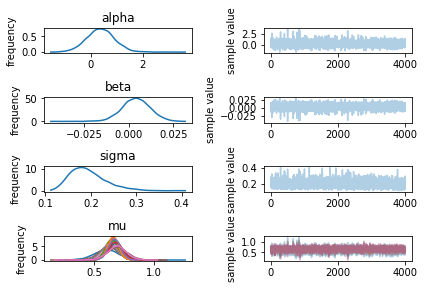

In [9]:
fit1_2.plot()
plt.tight_layout()
plt.show()

Let's now consider the logarithm of adult female body mass as an alternative predictor. Taking the logarithm of a predictor because:

> it is often true that scaling measurements like body mass are related by magnitudes to other variables. Taking the log of a measure translates the measure into magnitudes. So by using the logarithm of body mass hare, we're saying that we suspect that the magnitude of a mother's body mass is related to milk energy, in a linear fashion.

In [10]:
milk_cc['mass_log'] = np.log(milk_cc.loc[:, 'mass'])

/home/gianluca/.virtualenvs/rethinking/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [11]:
mass_data = dict(
    N=milk_cc.shape[0],
    X=milk_cc.loc[:, 'mass_log'],
    kcal_per_g=milk_cc.loc[:, 'kcal.per.g']
)

fit1_3 = sm1.sampling(data=mass_data)
fit1_3

Inference for Stan model: anon_model_aa94fcbabf321b641ccd10524dd27798.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha     0.7  1.3e-3   0.06   0.59   0.67    0.7   0.74   0.82   2166    1.0
beta    -0.03  5.4e-4   0.02  -0.08  -0.05  -0.03  -0.02   0.02   2049    1.0
sigma    0.18  8.3e-4   0.04   0.13   0.16   0.18    0.2   0.28   2091    1.0
mu[0]    0.68  9.8e-4   0.05   0.58   0.65   0.68   0.72   0.78   2585    1.0
mu[1]    0.65  7.1e-4   0.05   0.56   0.62   0.65   0.68   0.74   4000    1.0
mu[2]    0.65  7.1e-4   0.05   0.56   0.62   0.65   0.68   0.74   4000    1.0
mu[3]    0.68  8.9e-4   0.05   0.58   0.65   0.68   0.71   0.77   2859    1.0
mu[4]    0.72  1.4e-3   0.06   0.59   0.68   0.72   0.76   0.84   2047    1.0
mu[5]    0.77  2.3e-3    0.1   0.57   0.71   0.77   0.84   0.97   1891    1.0
mu[6]    0.73  1.6e-3   0.07   

In [12]:
multi_code = """
data {
    int<lower=0> N;
    int<lower=0> K;
    matrix[N, K] X;
    vector[N] kcal_per_g;
}
parameters {
    real alpha;
    vector[K] beta;
    real<lower=0> sigma;

}
transformed parameters {
    vector[N] mu;
    
    mu = alpha + X * beta;
}
model {
    alpha ~ normal(0, 100);
    beta ~ normal(0, 1);
    //sigma ~ uniform(0, 1);
    kcal_per_g ~ normal(mu, sigma);
}"""

sm2 = StanModel(model_code=multi_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ea22a8566e5131b1a7c134c5a0c0d720 NOW.


In [13]:
multi_data = dict(
    N=milk_cc.shape[0],
    K=2,
    X=milk_cc.loc[:, ['neocortex.perc', 'mass_log']],
    kcal_per_g=milk_cc.loc[:, 'kcal.per.g']
)

fit2_1 = sm2.sampling(data=multi_data)
fit2_1

Inference for Stan model: anon_model_ea22a8566e5131b1a7c134c5a0c0d720.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha    -1.09    0.02    0.6  -2.27   -1.5  -1.09  -0.69   0.08   1066    1.0
beta[0]   0.03  2.9e-4 9.3e-3 9.9e-3   0.02   0.03   0.03   0.05   1048    1.0
beta[1]   -0.1  8.4e-4   0.03  -0.15  -0.11   -0.1  -0.08  -0.04   1134    1.0
sigma     0.14  9.4e-4   0.03    0.1   0.12   0.14   0.16   0.22   1114    1.0
mu[0]     0.39  3.0e-3    0.1   0.19   0.32   0.39   0.46   0.59   1205    1.0
mu[1]     0.56  1.1e-3   0.05   0.47   0.53   0.56   0.59   0.65   1737    1.0
mu[2]     0.56  1.1e-3   0.05   0.46   0.53   0.56   0.59   0.65   1716    1.0
mu[3]     0.72  7.6e-4   0.04   0.64   0.69   0.72   0.74    0.8   2722    1.0
mu[4]     0.87  2.0e-3   0.07   0.73   0.83   0.88   0.92   1.02   1309    1.0
mu[5]     0.76  1.5e-

> By incorporating both predictor variables in the regression, the estimated association of both with the outcome has increased. The posterior mean for the association of neocortex percent has increased more than sixfold, and its 89% interval is not entirely above zero. The posterior mean for log body mass is more strongly negative.

# Multicollinearity

Let's see how multicollinearity can affect the posterior distributions of the predictor's coefficients.

In [14]:
milk.loc[:, ['perc.fat', 'perc.lactose']].corr()

,perc.fat,perc.lactose
perc.fat,1.000000,-0.941637
perc.lactose,-0.941637,1.000000


`perc.fat` and `perc.lactose` are strongly positively correlated. This causes multicollinearity.

Let's reuse the already compiled model `sm1`.

In [15]:
print(sm1.model_code)


data {
    int<lower=0> N;
    vector[N] X;
    vector[N] kcal_per_g;
}
parameters {
    real alpha;
    real beta;
    real<lower=0> sigma;

}
transformed parameters {
    vector[N] mu;
    
    mu = alpha + beta * X;
}
model {
    alpha ~ normal(0, 100);
    beta ~ normal(0, 1);
    //sigma ~ uniform(0, 1);
    kcal_per_g ~ normal(mu, sigma);
}


In [16]:
fat_data = dict(
    N=milk.shape[0],
    X=milk['perc.fat'],
    kcal_per_g = milk['kcal.per.g']
)

sm1.sampling(data=fat_data)

Inference for Stan model: anon_model_aa94fcbabf321b641ccd10524dd27798.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha     0.3  1.1e-3   0.04   0.22   0.27    0.3   0.32   0.37   1249    1.0
beta     0.01  2.5e-5 1.0e-3 8.0e-3 9.4e-3   0.01   0.01   0.01   1727    1.0
sigma    0.08  3.0e-4   0.01   0.06   0.07   0.08   0.09   0.11   1483    1.0
mu[0]    0.47  6.4e-4   0.02   0.42   0.45   0.47   0.48   0.51   1348    1.0
mu[1]    0.49  5.7e-4   0.02   0.45   0.48   0.49   0.51   0.54   1415    1.0
mu[2]    0.44  7.0e-4   0.03   0.39   0.42   0.44   0.46   0.49   1308    1.0
mu[3]    0.45  6.8e-4   0.02    0.4   0.43   0.45   0.47    0.5   1319    1.0
mu[4]    0.57  3.5e-4   0.02   0.54   0.56   0.57   0.59   0.61   2317    1.0
mu[5]    0.51  4.7e-4   0.02   0.47    0.5   0.51   0.53   0.55   1846    1.0
mu[6]     0.6  3.1e-4   0.02   

In [17]:
lactose_data = dict(
    N=milk.shape[0],
    X=milk['perc.lactose'],
    kcal_per_g = milk['kcal.per.g']
)

sm1.sampling(data=lactose_data)

Inference for Stan model: anon_model_aa94fcbabf321b641ccd10524dd27798.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha    1.17  1.3e-3   0.05   1.07   1.14   1.17    1.2   1.27   1437    1.0
beta    -0.01  2.5e-5 9.7e-4  -0.01  -0.01  -0.01-10.0e-3-8.7e-3   1460    nan
sigma    0.07  2.7e-4 9.9e-3   0.05   0.06   0.07   0.07   0.09   1363    1.0
mu[0]    0.45  4.6e-4   0.02    0.4   0.43   0.45   0.46   0.49   2195    1.0
mu[1]    0.49  3.7e-4   0.02   0.45   0.48   0.49    0.5   0.53   2523    1.0
mu[2]    0.44  4.9e-4   0.02   0.39   0.42   0.44   0.45   0.48   2136    1.0
mu[3]    0.41  5.5e-4   0.02   0.36   0.39   0.41   0.42   0.45   2009    1.0
mu[4]     0.6  2.1e-4   0.01   0.58    0.6    0.6   0.61   0.63   4000    1.0
mu[5]    0.58  2.2e-4   0.01   0.56   0.57   0.58   0.59   0.61   4000    1.0
mu[6]    0.67  2.3e-4   0.01  

In [18]:
print(sm2.model_code)


data {
    int<lower=0> N;
    int<lower=0> K;
    matrix[N, K] X;
    vector[N] kcal_per_g;
}
parameters {
    real alpha;
    vector[K] beta;
    real<lower=0> sigma;

}
transformed parameters {
    vector[N] mu;
    
    mu = alpha + X * beta;
}
model {
    alpha ~ normal(0, 100);
    beta ~ normal(0, 1);
    //sigma ~ uniform(0, 1);
    kcal_per_g ~ normal(mu, sigma);
}


In [19]:
multicollinearity_data = dict(
    N=milk.shape[0],
    K=2,
    X=milk.loc[:, ['perc.fat', 'perc.lactose']],
    kcal_per_g=milk.loc[:, 'kcal.per.g']
)

sm2.sampling(data=multicollinearity_data)

Inference for Stan model: anon_model_ea22a8566e5131b1a7c134c5a0c0d720.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha      1.0  7.3e-3   0.22   0.56   0.86    1.0   1.14   1.45    925    1.0
beta[0] 2.1e-3  8.6e-5 2.6e-3-3.1e-3 3.1e-4 2.1e-3 3.8e-3 7.4e-3    957    1.0
beta[1]-8.6e-3  8.8e-5 2.7e-3  -0.01  -0.01-8.6e-3-6.9e-3-3.2e-3    936    1.0
sigma     0.07  2.6e-4 9.9e-3   0.05   0.06   0.07   0.07   0.09   1439    1.0
mu[0]     0.45  3.3e-4   0.02   0.41   0.43   0.45   0.46   0.49   4000    1.0
mu[1]     0.49  2.9e-4   0.02   0.45   0.48   0.49    0.5   0.53   4000    1.0
mu[2]     0.43  3.5e-4   0.02   0.39   0.42   0.43   0.45   0.48   4000    1.0
mu[3]     0.41  4.9e-4   0.02   0.36   0.39   0.41   0.43   0.46   2554    1.0
mu[4]      0.6  3.3e-4   0.02   0.57   0.59    0.6   0.61   0.63   2249    1.0
mu[5]     0.57  6.5e-

# Many categories

In [20]:
milk.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


In [21]:
clade_dummies = pd.get_dummies(milk.clade, drop_first=True)
clade_dummies.head()

,New World Monkey,Old World Monkey,Strepsirrhine
0,0,0,1
1,0,0,1
2,0,0,1
3,0,0,1
4,0,0,1


In [22]:
categories_code = """
data {
    int N;
    int K;
    matrix[N, K] X;
    vector[N] k;
}
parameters {
    real alpha;
    vector[K] beta;
    real<lower=0> sigma;
}
transformed parameters {
    vector[N] mu;
    mu = alpha + X * beta;
}
model {
    sigma ~ uniform(0, 10);
    beta ~ normal(0, 1);
    alpha ~ normal(0.6, 10);
    k ~ normal(mu, sigma);
}"""

sm2_1 = StanModel(model_code=categories_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_dcc9319ed86ed1e9210a5d140ba8dc26 NOW.


In [23]:
categories_data = dict(
    N=milk.shape[0],
    K=clade_dummies.shape[1],
    X=clade_dummies.as_matrix(),
    k=milk['kcal.per.g']
)

fit2_1 = sm2_1.sampling(data=categories_data)
fit2_1

Inference for Stan model: anon_model_dcc9319ed86ed1e9210a5d140ba8dc26.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha     0.54  1.2e-3   0.04   0.46   0.51   0.54   0.57   0.63   1293    1.0
beta[0]   0.17  1.6e-3   0.06   0.05   0.13   0.17   0.21   0.29   1558    1.0
beta[1]   0.24  1.6e-3   0.07   0.11    0.2   0.24   0.29   0.38   1876    1.0
beta[2]  -0.03  1.6e-3   0.07  -0.18  -0.08  -0.04   0.01   0.11   1956    1.0
sigma     0.13  3.6e-4   0.02    0.1   0.12   0.13   0.14   0.17   2915    1.0
mu[0]     0.51  9.1e-4   0.06    0.4   0.47   0.51   0.55   0.62   4000    1.0
mu[1]     0.51  9.1e-4   0.06    0.4   0.47   0.51   0.55   0.62   4000    1.0
mu[2]     0.51  9.1e-4   0.06    0.4   0.47   0.51   0.55   0.62   4000    1.0
mu[3]     0.51  9.1e-4   0.06    0.4   0.47   0.51   0.55   0.62   4000    1.0
mu[4]     0.51  9.1e-

Alternatively, one can use a vector of intercepts paramaters, where each category has its own intercept. The results will be equivalent, but the results are now more easily interpretable.

In [24]:
categories_code = """
data {
    int N;
    int J;
    int<lower=1, upper=J> clade_id[N];
    vector[N] k;
}
parameters {
    real alpha[J];
    real<lower=0> sigma;
}
transformed parameters {
    real mu[N];
    
    for (n in 1:N) {
        mu[n] = alpha[clade_id[n]];
    }
}
model {
    sigma ~ uniform(0, 10);
    alpha ~ normal(0.6, 10);
    k ~ normal(mu, sigma);
}"""

sm2_1 = StanModel(model_code=categories_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_667a7a1f9a930dfdae11e04320e80ebf NOW.


In [25]:
milk['clade_id'] = pd.Categorical(milk.clade).codes + 1

In [26]:
categories_data2 = dict(
    N=milk.shape[0],
    J=4,
    clade_id=milk['clade_id'],
    k=milk['kcal.per.g']
)

fit2_2 = sm2_1.sampling(data=categories_data2)
fit2_2

Inference for Stan model: anon_model_667a7a1f9a930dfdae11e04320e80ebf.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha[0]   0.54  6.9e-4   0.04   0.46   0.52   0.55   0.57   0.63   4000    1.0
alpha[1]   0.71  7.1e-4   0.04   0.62   0.68   0.71   0.74    0.8   4000    1.0
alpha[2]   0.79  8.5e-4   0.05   0.68   0.75   0.79   0.82   0.89   4000    1.0
alpha[3]   0.51  9.7e-4   0.06   0.39   0.47   0.51   0.55   0.63   4000    1.0
sigma      0.13  3.4e-4   0.02    0.1   0.12   0.13   0.14   0.18   3284    1.0
mu[0]      0.51  9.7e-4   0.06   0.39   0.47   0.51   0.55   0.63   4000    1.0
mu[1]      0.51  9.7e-4   0.06   0.39   0.47   0.51   0.55   0.63   4000    1.0
mu[2]      0.51  9.7e-4   0.06   0.39   0.47   0.51   0.55   0.63   4000    1.0
mu[3]      0.51  9.7e-4   0.06   0.39   0.47   0.51   0.55   0.63   4000    1.0
mu[4]      